# 

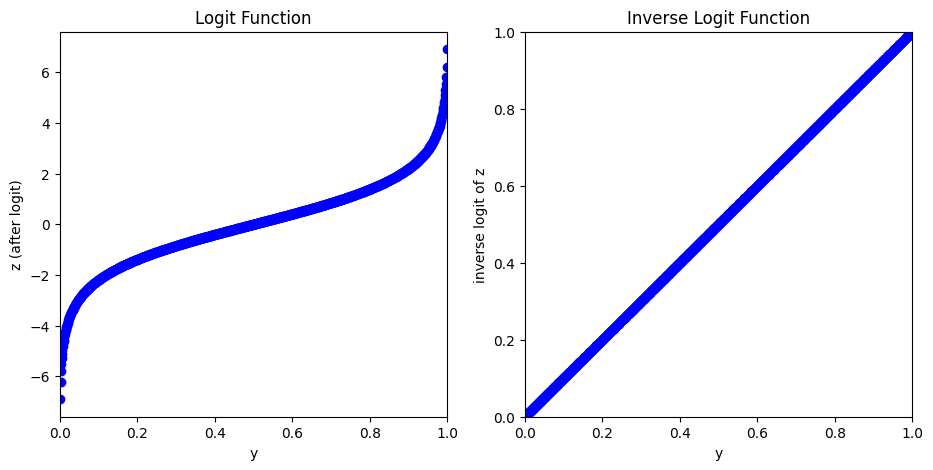

In [ ]:
# 03_03_logit

import matplotlib.pyplot as plt
import numpy as np

values = np.arange(0.001, 1, 0.001, dtype=float)
logit = np.log(values / (1 - values))
inverse_logit = np.exp(logit) / (1 + np.exp(logit))

fig, ax = plt.subplots(1, 2, squeeze=False, figsize=(11, 5))

fig1 = ax[0, 0]
fig1.scatter(values, logit, c="blue")
fig1.set_xlabel("y")
fig1.set_ylabel("z (after logit)")
fig1.set_xlim(0, 1)
fig1.set_title("Logit Function")

fig2 = ax[0, 1]
fig2.scatter(values, inverse_logit, c="blue")
fig2.set_xlabel("y")
fig2.set_ylabel("inverse logit of z")
fig2.set_xlim(0, 1)
fig2.set_ylim(0, 1)
fig2.set_title("Inverse Logit Function")
plt.show()


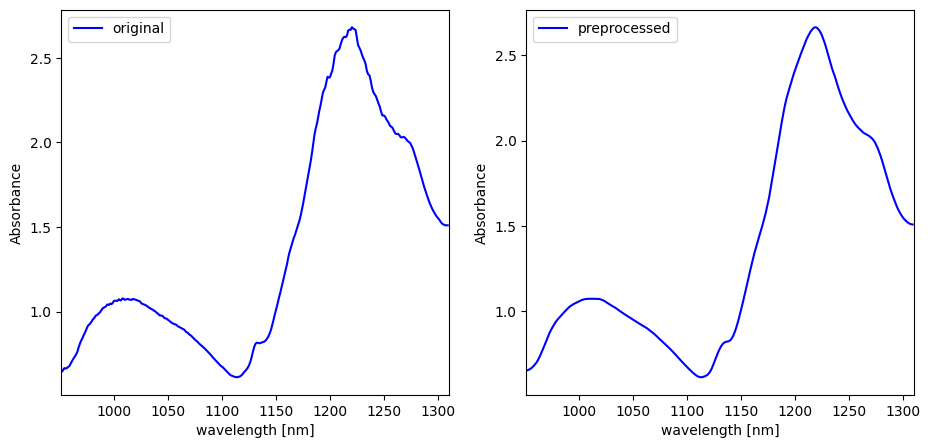

In [ ]:
# 03_04_sg

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from scipy.signal import savgol_filter

# SG法の設定値
window_length = 21  # 窓枠の数
poly_order = 2  # 多項式の次数
deriv = 0  # 微分次数 (0 は微分なし)
plot_spectra_number = 12  # 表示するスペクトルのサンプル番号 (0, 1, ..., 227)

csv_path = Path("dataset/sample_spectra_dataset.csv")
preprocessed_csv_path = Path(
    f"dataset/preprocessed_sample_spectra_dataset_w{window_length}_p{poly_order}_d{deriv}.csv"
)

# データセットの読み込み
x = pl.read_csv(csv_path).drop("")
# SG 法
preprocessed_x = savgol_filter(
    x.to_numpy(), window_length=window_length, polyorder=poly_order, deriv=deriv
)
# pl.DataFrameに変換してcsvとして保存
preprocessed_x = pl.DataFrame(preprocessed_x, schema=x.schema)
preprocessed_x.with_row_index("").write_csv(preprocessed_csv_path)

# プロット
fig, ax = plt.subplots(1, 2, squeeze=False, figsize=(11, 5))
wave_lengths = np.array(x.columns, dtype="float64")
fig1 = ax[0, 0]
fig1.plot(wave_lengths, x.row(plot_spectra_number), "b-", label="original")
fig1.set_xlabel("wavelength [nm]")
fig1.set_ylabel("Absorbance")
fig1.set_xlim(wave_lengths[0] - 1, wave_lengths[-1] + 1)
fig1.legend()

fig2 = ax[0, 1]
fig2.plot(
    wave_lengths,
    preprocessed_x.row(plot_spectra_number),
    "b-",
    label="preprocessed",
)
fig2.set_xlabel("wavelength [nm]")
fig2.set_ylabel("Absorbance")
fig2.set_xlim(wave_lengths[0] - 1, wave_lengths[-1] + 1)
fig2.legend()
plt.show()


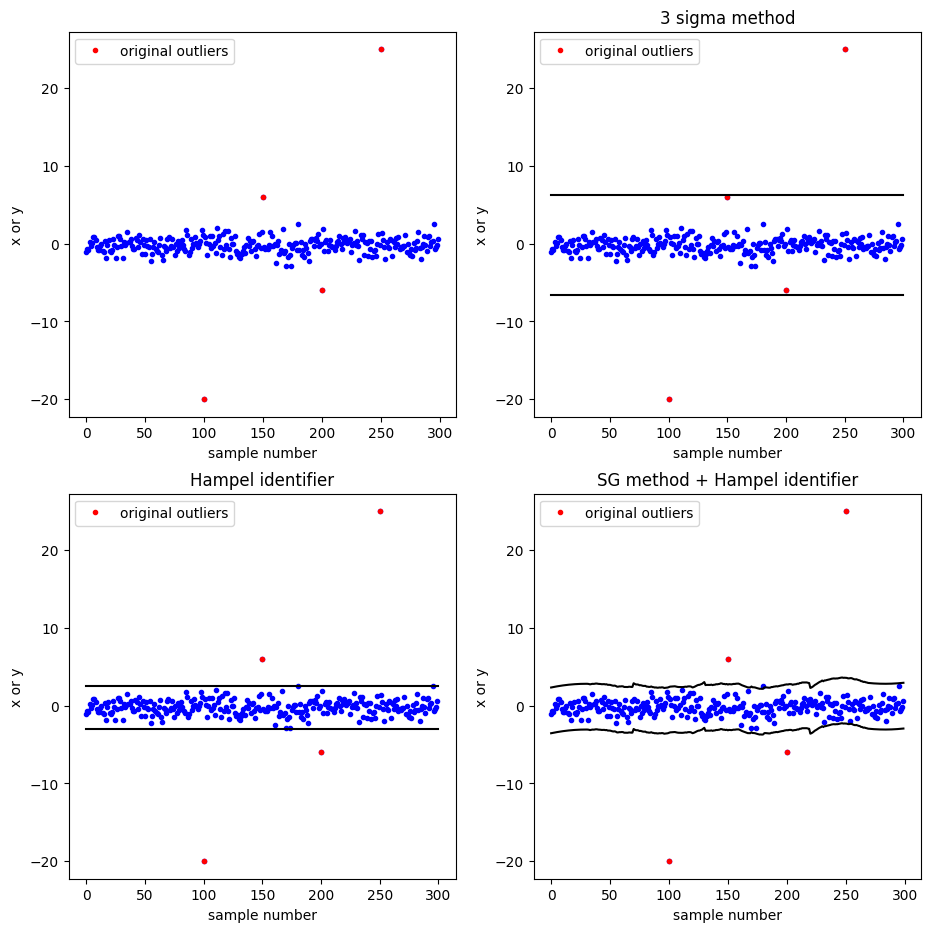

In [4]:
# 03_05_outlier

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# 設定 ここから
type_of_samples = 0  # 仮想サンプルの種類 0:正規乱数、1:時系列
window_length = 61  # SG 法における窓枠の数
poly_order = 2  # SG 法における多項式の次数
deriv = 0  # SG 法における微分次数 (0 は微分なし)
number_of_samples = 300  # 仮想サンプルの数
noise_rate = 8  # SN比

rng = np.random.default_rng(seed=10)

if type_of_samples == 0:
    outliers = [-20, 6, -6, 25]  # 外れ値
    outlier_indexes = [100, 150, 200, 250]  # 外れ値のインデックス
    x = rng.standard_normal(number_of_samples)
elif type_of_samples == 1:
    outliers = [1, 3, 10, -2]  # %外れ値
    outlier_indexes = [80, 150, 200, 250]  # 外れ値のインデックス
    x = np.sin(np.arange(number_of_samples) * np.pi / 50)
    noise = rng.standard_normal(number_of_samples)
    noise = noise * (x.var() / noise_rate) ** 0.5
    x += noise
x[outlier_indexes] = outliers  # 外れ値の追加

fig, ax = plt.subplots(2, 2, squeeze=False, figsize=(11, 11))

fig1 = ax[0, 0]
fig1.plot(x, "b.")  # プロット
fig1.plot(
    outlier_indexes, x[outlier_indexes], "r.", label="original outliers"
)  # プロット
fig1.set_xlabel("sample number")  # x 軸の名前
fig1.set_ylabel("x or y")  # y 軸の名前
fig1.legend()


# 3 sigma method
upper_3_sigma = x.mean() + 3 * x.std()
lower_3_sigma = x.mean() - 3 * x.std()
fig2 = ax[0, 1]
fig2.plot(x, "b.")
fig2.plot(outlier_indexes, x[outlier_indexes], "r.", label="original outliers")
fig2.plot([0, len(x)], [upper_3_sigma, upper_3_sigma], "k-")
fig2.plot([0, len(x)], [lower_3_sigma, lower_3_sigma], "k-")
fig2.set_xlabel("sample number")  # x 軸の名前
fig2.set_ylabel("x or y")  # y 軸の名前
fig2.set_title("3 sigma method")
fig2.legend()

# Hampel identifier
upper_hampel = np.median(x) + 3 * 1.4826 * np.median(np.absolute(x - np.median(x)))
lower_hampel = np.median(x) - 3 * 1.4826 * np.median(np.absolute(x - np.median(x)))
fig3 = ax[1, 0]
fig3.plot(x, "b.")
fig3.plot(outlier_indexes, x[outlier_indexes], "r.", label="original outliers")
fig3.plot([0, len(x)], [upper_hampel, upper_hampel], "k-")
fig3.plot([0, len(x)], [lower_hampel, lower_hampel], "k-")
fig3.set_xlabel("sample number")  # x 軸の名前
fig3.set_ylabel("x or y")  # y 軸の名前
fig3.set_title("Hampel identifier")
fig3.legend()

# SG method + Hampel identifier
preprocessed_x = savgol_filter(
    x, window_length=window_length, polyorder=poly_order, deriv=deriv
)  # SG 法
x_diff = x - preprocessed_x
upper_sg_hampel = (
    preprocessed_x
    + np.median(x_diff)
    + 3 * 1.4826 * np.median(np.absolute(x_diff - np.median(x_diff)))
)
lower_sg_hampel = (
    preprocessed_x
    + np.median(x_diff)
    - 3 * 1.4826 * np.median(np.absolute(x_diff - np.median(x_diff)))
)
fig4 = ax[1, 1]
fig4.plot(x, "b.")
fig4.plot(outlier_indexes, x[outlier_indexes], "r.", label="original outliers")
fig4.plot(range(len(x)), upper_sg_hampel, "k-")
fig4.plot(range(len(x)), lower_sg_hampel, "k-")
fig4.set_xlabel("sample number")  # x 軸の名前
fig4.set_ylabel("x or y")  # y 軸の名前
fig4.set_title("SG method + Hampel identifier")
fig4.legend()
plt.show()  # 以上の設定で描画
